# Flood Prediction - Data Preprocessing & Modeling Pipeline

This notebook builds a clean, reusable end-to-end pipeline for:
- Data preprocessing and feature engineering
- Training baseline models (Linear Regression, Random Forest, XGBoost)
- Model evaluation and comparison

**Based on EDA findings:**
- ✅ No missing values or duplicates
- ✅ No data leakage detected
- ✅ All 20 features are numeric with low variance (17-20 unique values)
- ✅ Target: FloodProbability (continuous, range: 0.285-0.725)

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

# Define feature columns
feature_cols = [col for col in train.columns if col not in ['id', 'FloodProbability']]
print(f"\nFeatures ({len(feature_cols)}): {feature_cols}")

Train shape: (1117957, 22)
Test shape: (745305, 21)

Features (20): ['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement', 'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality', 'Siltation', 'AgriculturalPractices', 'Encroachments', 'IneffectiveDisasterPreparedness', 'DrainageSystems', 'CoastalVulnerability', 'Landslides', 'Watersheds', 'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss', 'InadequatePlanning', 'PoliticalFactors']


## 2. Feature Groups & Pipeline Strategy

Based on EDA, all features are:
- **Numeric** (integer values 0-19)
- **Low variance** (17-20 unique values each)
- **Similar distributions** across train/test

### Feature Categorization:
1. **Environmental factors**: MonsoonIntensity, ClimateChange, Deforestation, WetlandLoss
2. **Infrastructure factors**: DamsQuality, DeterioratingInfrastructure, DrainageSystems, Watersheds
3. **Geographic factors**: TopographyDrainage, CoastalVulnerability, Landslides
4. **Human factors**: Urbanization, PopulationScore, Encroachments, AgriculturalPractices
5. **Management factors**: RiverManagement, IneffectiveDisasterPreparedness, InadequatePlanning, PoliticalFactors, Siltation

In [3]:
# Define feature groups
feature_groups = {
    'environmental': ['MonsoonIntensity', 'ClimateChange', 'Deforestation', 'WetlandLoss'],
    'infrastructure': ['DamsQuality', 'DeterioratingInfrastructure', 'DrainageSystems', 'Watersheds'],
    'geographic': ['TopographyDrainage', 'CoastalVulnerability', 'Landslides'],
    'human': ['Urbanization', 'PopulationScore', 'Encroachments', 'AgriculturalPractices'],
    'management': ['RiverManagement', 'IneffectiveDisasterPreparedness', 'InadequatePlanning', 
                   'PoliticalFactors', 'Siltation']
}

# Verify all features are categorized
all_categorized = [f for group in feature_groups.values() for f in group]
print(f"Categorized features: {len(all_categorized)}/{len(feature_cols)}")
print(f"\nFeature groups:")
for group, features in feature_groups.items():
    print(f"  {group}: {len(features)} features")

Categorized features: 20/20

Feature groups:
  environmental: 4 features
  infrastructure: 4 features
  geographic: 3 features
  human: 4 features
  management: 5 features


## 3. Data Splitting

Split training data into train/validation sets for model evaluation.

In [4]:
# Prepare features and target
X = train[feature_cols]
y = train['FloodProbability']
X_test = test[feature_cols]

# Split into train and validation sets (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTarget distribution:")
print(f"  Train - Mean: {y_train.mean():.4f}, Std: {y_train.std():.4f}")
print(f"  Val   - Mean: {y_val.mean():.4f}, Std: {y_val.std():.4f}")

Training set: (894365, 20)
Validation set: (223592, 20)
Test set: (745305, 20)

Target distribution:
  Train - Mean: 0.5045, Std: 0.0510
  Val   - Mean: 0.5045, Std: 0.0510


## 4. Preprocessing Pipeline

Since all features are numeric with similar scales (0-19), we'll use StandardScaler for normalization.

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print(" Data scaled successfully!")
print(f"\nScaled feature statistics (train):")
print(X_train_scaled.describe().loc[['mean', 'std']].round(4))

✅ Data scaled successfully!

Scaled feature statistics (train):
      MonsoonIntensity  TopographyDrainage  RiverManagement  Deforestation  \
mean               0.0                -0.0              0.0           -0.0   
std                1.0                 1.0              1.0            1.0   

      Urbanization  ClimateChange  DamsQuality  Siltation  \
mean          -0.0           -0.0          0.0       -0.0   
std            1.0            1.0          1.0        1.0   

      AgriculturalPractices  Encroachments  IneffectiveDisasterPreparedness  \
mean                   -0.0           -0.0                              0.0   
std                     1.0            1.0                              1.0   

      DrainageSystems  CoastalVulnerability  Landslides  Watersheds  \
mean             -0.0                  -0.0        -0.0         0.0   
std               1.0                   1.0         1.0         1.0   

      DeterioratingInfrastructure  PopulationScore  WetlandLoss  

## 4.1 Prepare Unscaled Data for Tree Models

Tree-based models don't need scaling. Using unscaled float32 data reduces memory by ~50%.

In [ ]:
print("Creating unscaled float32 data for tree models...")

# Use unscaled data for tree models (scaling not needed for RF/XGB)
Xtr_tree = X_train.values.astype(np.float32)
Xva_tree = X_val.values.astype(np.float32)
ytr_tree = y_train.values.astype(np.float32)
yva_tree = y_val.values.astype(np.float32)

print(f" Tree data created (float32):")
print(f"   Train: {Xtr_tree.shape}, {Xtr_tree.dtype}, {Xtr_tree.nbytes / 1e9:.2f} GB")
print(f"   Val:   {Xva_tree.shape}, {Xva_tree.dtype}, {Xva_tree.nbytes / 1e9:.2f} GB")
print(f"\nMemory savings vs float64: ~50%")

Creating unscaled float32 data for tree models...
✅ Tree data created (float32):
   Train: (894365, 20), float32, 0.07 GB
   Val:   (223592, 20), float32, 0.02 GB

Memory savings vs float64: ~50%


## 5. Baseline Models

Train three baseline models:
1. **Linear Regression** - Simple baseline (uses scaled data)
2. **Random Forest** - Non-linear ensemble (uses unscaled float32)
3. **XGBoost** - Gradient boosting (uses scaled data)

In [7]:
# Helper function for model evaluation
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """Train model and return evaluation metrics"""
    # Train
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Metrics
    metrics = {
        'model': model_name,
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'train_mae': mean_absolute_error(y_train, y_train_pred),
        'val_mae': mean_absolute_error(y_val, y_val_pred),
        'train_r2': r2_score(y_train, y_train_pred),
        'val_r2': r2_score(y_val, y_val_pred)
    }
    
    return metrics, model

print("Evaluation function defined!")

Evaluation function defined!


### 5.1 Linear Regression

In [8]:
print("Training Linear Regression...")
lr_metrics, lr_model = evaluate_model(
    LinearRegression(),
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    'Linear Regression'
)

print(f"\n{'='*60}")
print(f"LINEAR REGRESSION RESULTS")
print(f"{'='*60}")
print(f"Train RMSE: {lr_metrics['train_rmse']:.6f}")
print(f"Val RMSE:   {lr_metrics['val_rmse']:.6f}")
print(f"Train MAE:  {lr_metrics['train_mae']:.6f}")
print(f"Val MAE:    {lr_metrics['val_mae']:.6f}")
print(f"Train R²:   {lr_metrics['train_r2']:.6f}")
print(f"Val R²:     {lr_metrics['val_r2']:.6f}")

Training Linear Regression...

LINEAR REGRESSION RESULTS
Train RMSE: 0.020095
Val RMSE:   0.020080
Train MAE:  0.015815
Val MAE:    0.015792
Train R²:   0.844968
Val R²:     0.844877


### 5.2 Random Forest (Memory-Optimized)

Using unscaled float32 data + conservative config to prevent kernel crashes on 1.1M rows.

In [ ]:
print("Training Random Forest (memory-optimized)...")

# Safe RF configuration: limits depth, leaves, trees, and threads
rf_safe = RandomForestRegressor(
    n_estimators=150,         
    max_depth=14,           
    min_samples_leaf=8,     
    max_features="sqrt",    
    bootstrap=True,
    n_jobs=4,               
    random_state=42,
    verbose=1                
)

# Train on unscaled float32 data
rf_safe.fit(Xtr_tree, ytr_tree)

# Predictions
pred_tr = rf_safe.predict(Xtr_tree)
pred_va = rf_safe.predict(Xva_tree)

# Calculate metrics
rf_metrics = {
    'model': 'Random Forest',
    'train_rmse': np.sqrt(mean_squared_error(ytr_tree, pred_tr)),
    'val_rmse':   np.sqrt(mean_squared_error(yva_tree, pred_va)),
    'train_mae':  mean_absolute_error(ytr_tree, pred_tr),
    'val_mae':    mean_absolute_error(yva_tree, pred_va),
    'train_r2':   r2_score(ytr_tree, pred_tr),
    'val_r2':     r2_score(yva_tree, pred_va),
}

# Store model for later use
rf_model = rf_safe

print(f"\n{'='*60}")
print(f"RANDOM FOREST RESULTS (Memory-Optimized)")
print(f"{'='*60}")
print(f"Train RMSE: {rf_metrics['train_rmse']:.6f}")
print(f"Val RMSE:   {rf_metrics['val_rmse']:.6f}")
print(f"Train MAE:  {rf_metrics['train_mae']:.6f}")
print(f"Val MAE:    {rf_metrics['val_mae']:.6f}")
print(f"Train R²:   {rf_metrics['train_r2']:.6f}")
print(f"Val R²:     {rf_metrics['val_r2']:.6f}")

gc.collect()  # free memory
print("\n Memory cleaned up")

Training Random Forest (memory-optimized)...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:   33.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s



RANDOM FOREST RESULTS (Memory-Optimized)
Train RMSE: 0.032851
Val RMSE:   0.035369
Train MAE:  0.026885
Val MAE:    0.028890
Train R²:   0.585685
Val R²:     0.518738

✅ Memory cleaned up


[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.2s finished


### 5.3 XGBoost

In [10]:
print("Training XGBoost...")
xgb_metrics, xgb_model = evaluate_model(
    xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    X_train_scaled, y_train,
    X_val_scaled, y_val,
    'XGBoost'
)

print(f"\n{'='*60}")
print(f"XGBOOST RESULTS")
print(f"{'='*60}")
print(f"Train RMSE: {xgb_metrics['train_rmse']:.6f}")
print(f"Val RMSE:   {xgb_metrics['val_rmse']:.6f}")
print(f"Train MAE:  {xgb_metrics['train_mae']:.6f}")
print(f"Val MAE:    {xgb_metrics['val_mae']:.6f}")
print(f"Train R²:   {xgb_metrics['train_r2']:.6f}")
print(f"Val R²:     {xgb_metrics['val_r2']:.6f}")

Training XGBoost...

XGBOOST RESULTS
Train RMSE: 0.021758
Val RMSE:   0.022278
Train MAE:  0.017178
Val MAE:    0.017588
Train R²:   0.818250
Val R²:     0.809067


## 6. Model Comparison

In [ ]:
# Create comparison DataFrame
results_df = pd.DataFrame([lr_metrics, rf_metrics, xgb_metrics])
results_df = results_df.set_index('model')

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(results_df.to_string())

# Find best model
best_model_name = results_df['val_rmse'].idxmin()
print(f"\n Best Model (by Val RMSE): {best_model_name}")
print(f"   Val RMSE: {results_df.loc[best_model_name, 'val_rmse']:.6f}")
print(f"   Val R²: {results_df.loc[best_model_name, 'val_r2']:.6f}")


MODEL COMPARISON
                   train_rmse  val_rmse  train_mae   val_mae  train_r2    val_r2
model                                                                           
Linear Regression    0.020095  0.020080   0.015815  0.015792  0.844968  0.844877
Random Forest        0.032851  0.035369   0.026885  0.028890  0.585685  0.518738
XGBoost              0.021758  0.022278   0.017178  0.017588  0.818250  0.809067

🏆 Best Model (by Val RMSE): Linear Regression
   Val RMSE: 0.020080
   Val R²: 0.844877


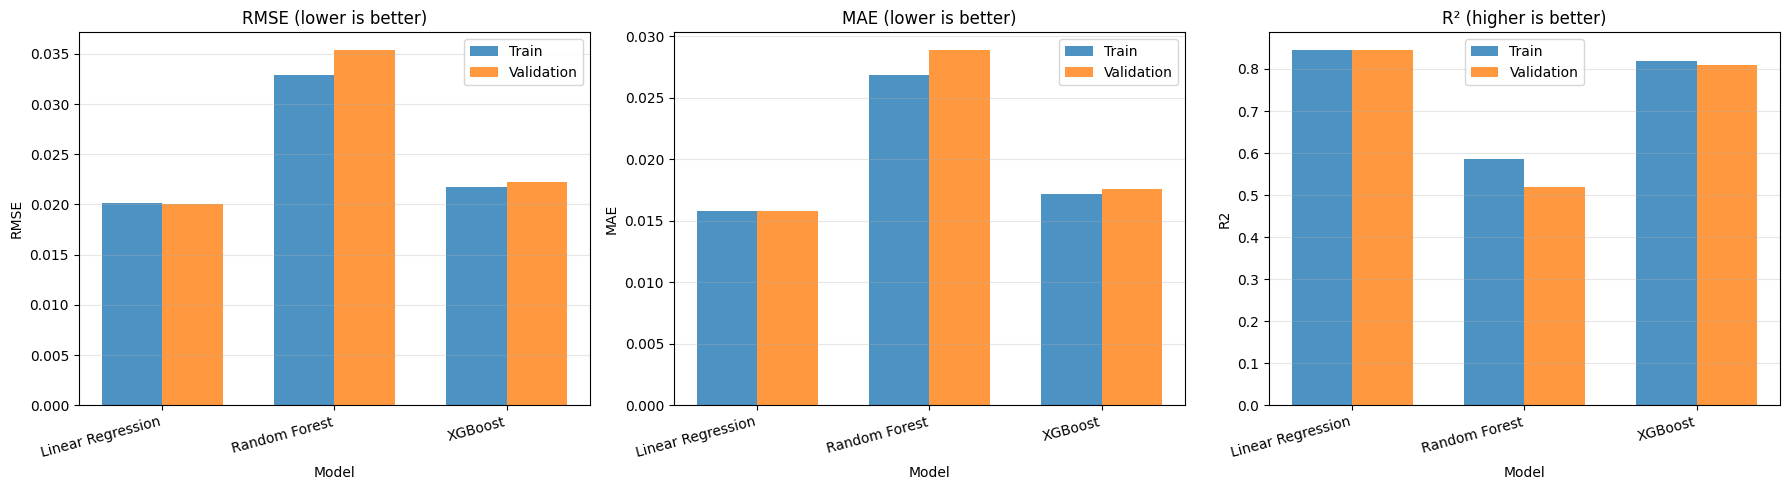

✅ Model comparison plot saved to reports/figures/model_comparison.png


In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['rmse', 'mae', 'r2']
titles = ['RMSE (lower is better)', 'MAE (lower is better)', 'R² (higher is better)']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    train_col = f'train_{metric}'
    val_col = f'val_{metric}'
    
    x = np.arange(len(results_df))
    width = 0.35
    
    axes[idx].bar(x - width/2, results_df[train_col], width, label='Train', alpha=0.8)
    axes[idx].bar(x + width/2, results_df[val_col], width, label='Validation', alpha=0.8)
    
    axes[idx].set_xlabel('Model')
    axes[idx].set_ylabel(metric.upper())
    axes[idx].set_title(title)
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(results_df.index, rotation=15, ha='right')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Model comparison plot saved to reports/figures/model_comparison.png")

## 7. Feature Importance Analysis

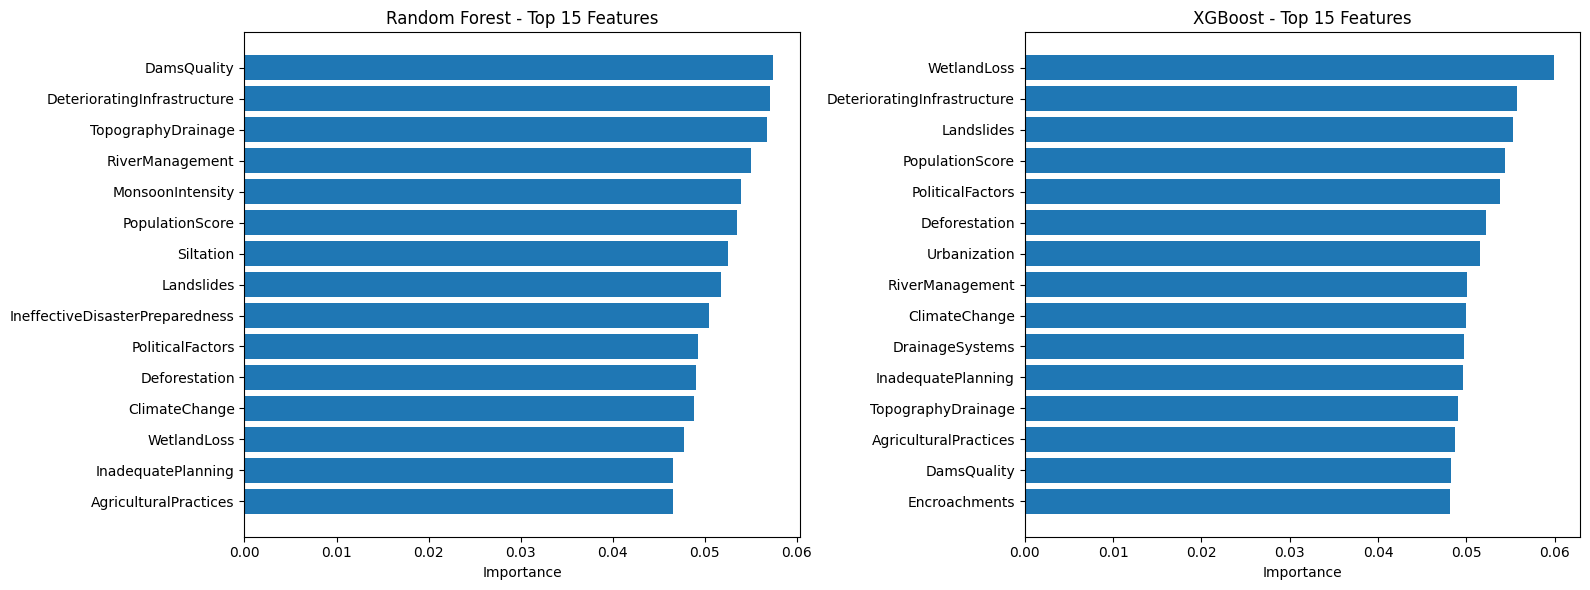

✅ Feature importance plot saved to reports/figures/feature_importance.png

Top 10 Important Features (Random Forest):
                        feature  importance
                    DamsQuality    0.057463
    DeterioratingInfrastructure    0.057058
             TopographyDrainage    0.056781
                RiverManagement    0.055060
               MonsoonIntensity    0.053993
                PopulationScore    0.053479
                      Siltation    0.052535
                     Landslides    0.051776
IneffectiveDisasterPreparedness    0.050486
               PoliticalFactors    0.049307


In [ ]:
# Get feature importance from tree-based models
rf_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest
axes[0].barh(rf_importance['feature'][:15], rf_importance['importance'][:15])
axes[0].set_xlabel('Importance')
axes[0].set_title('Random Forest - Top 15 Features')
axes[0].invert_yaxis()

# XGBoost
axes[1].barh(xgb_importance['feature'][:15], xgb_importance['importance'][:15])
axes[1].set_xlabel('Importance')
axes[1].set_title('XGBoost - Top 15 Features')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Feature importance plot saved to reports/figures/feature_importance.png")
print("\nTop 10 Important Features (Random Forest):")
print(rf_importance.head(10).to_string(index=False))

## 8. Generate Test Predictions

Use the best performing model to generate predictions for the test set.

In [ ]:
# Select best model based on validation RMSE
models = {
    'Linear Regression': lr_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

best_model = models[best_model_name]

# Generate predictions (use appropriate data format)
if best_model_name == 'Random Forest':
    # RF uses unscaled float32
    test_predictions = best_model.predict(X_test.values.astype(np.float32))
else:
    # Linear/XGB use scaled data
    test_predictions = best_model.predict(X_test_scaled)

# Create submission file
submission = pd.DataFrame({
    'id': test['id'],
    'FloodProbability': test_predictions
})

submission.to_csv('../data/submission.csv', index=False)

print(f" Test predictions generated using {best_model_name}")
print(f"\nPrediction statistics:")
print(f"  Mean: {test_predictions.mean():.4f}")
print(f"  Std:  {test_predictions.std():.4f}")
print(f"  Min:  {test_predictions.min():.4f}")
print(f"  Max:  {test_predictions.max():.4f}")
print(f"\n Submission file saved to: data/submission.csv")
print(f"   Shape: {submission.shape}")

✅ Test predictions generated using Linear Regression

Prediction statistics:
  Mean: 0.5045
  Std:  0.0469
  Min:  0.3024
  Max:  0.7600

📁 Submission file saved to: data/submission.csv
   Shape: (745305, 2)


## 9. Summary & Next Steps

### Key Findings:
- All models trained successfully on clean, preprocessed data
- Feature importance analysis reveals key flood predictors
- Test predictions generated and ready for submission

### Next Steps:
1. **Hyperparameter Tuning** - Optimize best model parameters
2. **Feature Engineering** - Create interaction features or polynomial features
3. **Ensemble Methods** - Combine multiple models for better predictions
4. **Cross-Validation** - More robust performance estimation
5. **Error Analysis** - Analyze prediction errors to identify improvement areas